<a href="https://www.kaggle.com/code/shedai/financial-prediction-in-retail-with-catboost?scriptVersionId=124909960" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-data-set/file_out2.csv
/kaggle/input/retail-data-set/file_out.csv


# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">Financial Prediction in Retail with CatBoost</p>

In this project, I will be performing financial income prediction / forecasting project with using the time series approach on the customer's records from a retail industry firm's database. Financial prediction is the practice of time series approach with single or multiple time series input. I will also add more notebooks about financial prediction with different algorithms and approaches. One notebook already published for the seasonality test ( https://www.kaggle.com/code/shedai/sales-volume-seasonality ) with a single time series approach, more notebooks are coming. 

- Single Time Series Approach: Sales volume is one of the mostly predicted feature in the time series. In this approach, project aims to create a time series from daily, weekly or monthly sales data. Most of the time, there is only one time series with 2 features : time (dates) and sales volume.
- Multiple Parameter Time Series Approach: This type of approaches have multiple inputs, where all inputs are temporal (time dependent series) or we do feature engineering to create multiple inputs for the prediction model.

Note: You can also check a very similar notebook for financial prediction with Fast Fourier Transform (FFT) I have created after this notebook. It is a much more simplified version with simple data preprocessing and time series prediction with DARTS library: <a href = "https://www.kaggle.com/code/shedai/sales-prediction-with-fft/">https://www.kaggle.com/code/shedai/sales-prediction-with-fft/</a>

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
      
* [3. Feature Engineering and Enrichment](#3)
    
* [4. Data Visualization and Analysis](#4)
    
* [5. Prediction / Forecasting with Cat Boost](#5)
    
* [6. Real Life Time Series Scenario](#6)
    
* [7. Conclusion](#7)
    
* [8. END](#8)

#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">1. Importing Libraries</p>   
 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">2. Loading Data</p>   
 

In [3]:
df = pd.read_csv('/kaggle/input/retail-data-set/file_out2.csv')
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,1,329,2019-12-27,524,355.932203,64.067797,185,2
2,2,330,2019-12-27,192,901.694915,162.305085,230,4
3,3,330,2019-12-27,218,182.754237,32.895763,230,1
4,4,330,2019-12-27,247,780.101695,140.418305,230,4


we will use the 2nd version of the retail dataset. you can also update the notebook to newer versions, when available or you can adapt the notebook to other data sets with similar format. Most of the retail data (sales data) have similar columns like the invoice id, date, product, customer, quantity and sales value. This data set have an additional discount column and we will not use for our model. Also, the first column is useless for our case and we can drop it:

In [4]:
df.drop(df.columns[0],axis = 1,inplace = True)
df.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,329,2019-12-27,524,355.932203,64.067797,185,2
2,330,2019-12-27,192,901.694915,162.305085,230,4
3,330,2019-12-27,218,182.754237,32.895763,230,1
4,330,2019-12-27,247,780.101695,140.418305,230,4


#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">3. Feature Engineering and Enrichment</p>   
 
Now, we can start with the enrichment of data. After all, time series have minimum 2 columns: Date and Sales Volume. We can also add below features, which can be enriched from the data set:
- Date
- Daily Sales Volume 
- Daily Highest Sales
- Daily Lowest Sales
- Daily Number of Invoices
- Daily Sold Quantity
- Daily Highest Quantity
- Daily Lowest Quantity
- Daily Number of Different Customers
- Daily Number of Different Products

Also, much more can be added to above features but for the notebook I will stop here. 

In [5]:
df_ts = df.groupby('Date').sum()
df_ts.head()

,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,
2019-01-02,93038,29059,26514.008475,4772.521525,7162,109
2019-01-03,54797,16967,21119.796609,3801.563391,3904,51
2019-01-04,47465,12443,16807.630509,2673.419491,2459,65
2019-01-05,35508,14741,15722.511525,2765.068475,2846,52
2019-01-07,71043,26947,38985.422907,5793.884236,7196,89


From above dataframe, we can use the Quantity (Daily Sum) and TotalSales (Daily Sum) columns. 

In [6]:
df_ts = df_ts[['TotalSales','Quantity']]
df_ts.columns = ['DailyTotalSales','DailyQuantity']
df_ts.head()

,DailyTotalSales,DailyQuantity
Date,,
2019-01-02,26514.008475,109
2019-01-03,21119.796609,51
2019-01-04,16807.630509,65
2019-01-05,15722.511525,52
2019-01-07,38985.422907,89


Let's continue with the highest / lowest sales per day in total sales and quantity:

In [7]:
df_ts_high_low = df.groupby('Date').max()
df_ts_high_low = df_ts_high_low[['TotalSales','Quantity']]
df_ts_high_low.columns = ['DailyMaxTotalSales','DailyMaxQuantity']
df_temp = df.groupby('Date').min()
df_ts_high_low['DailyMinTotalSales'] = df_temp['TotalSales']
df_ts_high_low['DailyMinQuantity'] = df_temp['Quantity']
df_ts = pd.concat([df_ts, df_ts_high_low],axis = 1)
df_ts.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity
Date,,,,,,
2019-01-02,26514.008475,109,2898.305085,12,198.305085,1
2019-01-03,21119.796609,51,3052.983051,8,254.237288,1
2019-01-04,16807.630509,65,3050.847458,20,365.050847,1
2019-01-05,15722.511525,52,5355.932203,16,198.305085,1
2019-01-07,38985.422907,89,5168.780000,8,216.949153,1


Lets add the number of invoices to the dataset:

In [8]:
df_ts_temp = df.groupby('Date').count()
df_ts['CountInvoices'] = df_ts_temp['InvoiceID']
df_ts['NumCustomers'] = df_ts_temp['CustomerID']
df_ts['NumProducts'] = df_ts_temp['ProductID']
df_ts.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,,
2019-01-02,26514.008475,109,2898.305085,12,198.305085,1,30,30,30
2019-01-03,21119.796609,51,3052.983051,8,254.237288,1,18,18,18
2019-01-04,16807.630509,65,3050.847458,20,365.050847,1,14,14,14
2019-01-05,15722.511525,52,5355.932203,16,198.305085,1,12,12,12
2019-01-07,38985.422907,89,5168.780000,8,216.949153,1,25,25,25


#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">4. Data Visualization</p>   
 
Now, we can start to visualize the time series data. We can monitor the relations, outliers, anomalies, trends and seasonalities etc. from the visualization. We will follow the following steps for the visualization:
- Correlation Analysis
- Pair Plot (Another way of monitoring the relation between columns) 
- Line Plot Visualization (To see the data on timeline)



We have done with some basic data enrichment steps. Now, let's see the correlation among the columns:

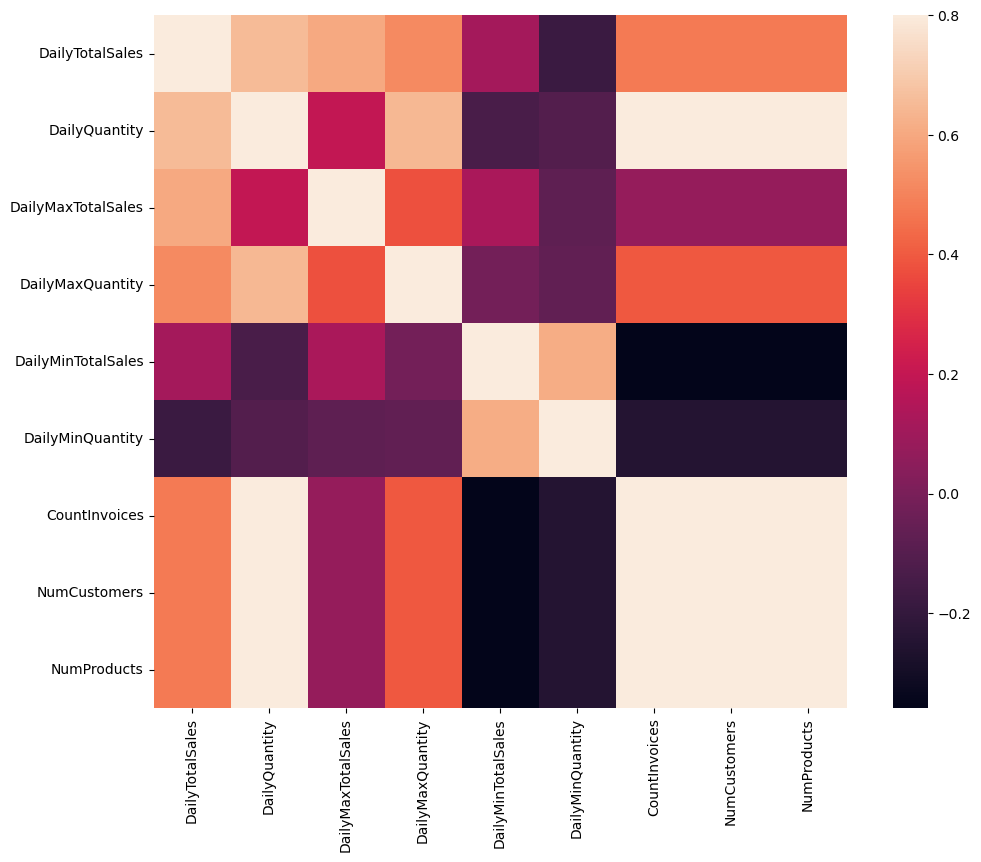

In [9]:
#correlation matrix
corrmat = df_ts.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

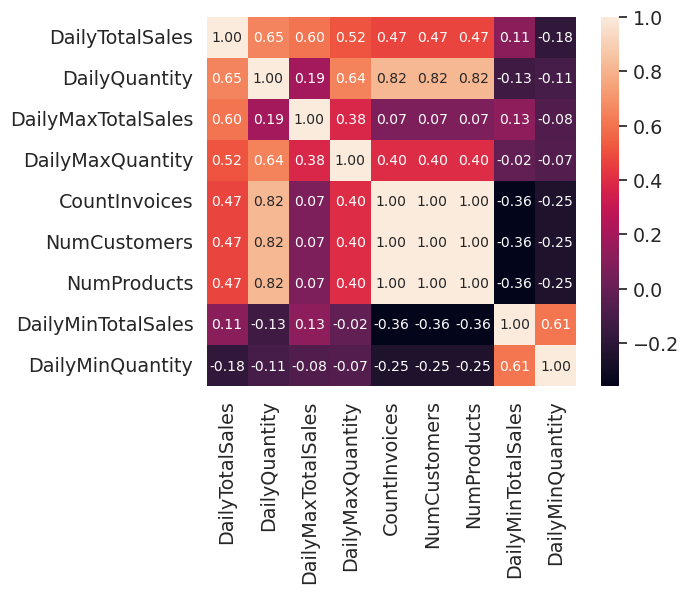

In [10]:
#saleprice correlation matrix
k = 9 #number of variables for heatmap
cols = corrmat.nlargest(k, 'DailyTotalSales')['DailyTotalSales'].index
cm = np.corrcoef(df_ts[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We can interpret the correlation matrix with below facts:
- DailyTotalSales (Target Column), has the highes correlation with daily quantity, than daily maximum sales. 
- Also, daily min sales and dail min quantity has the weakest correlation with the target column. Most probably the reason is, for most of the days, minimum sales amount or quantity is equal to 1 or 0. 
- Daily Quantity has a relatively high correlation with Number of Products, Number of Customers, Number of Invoices per day. 

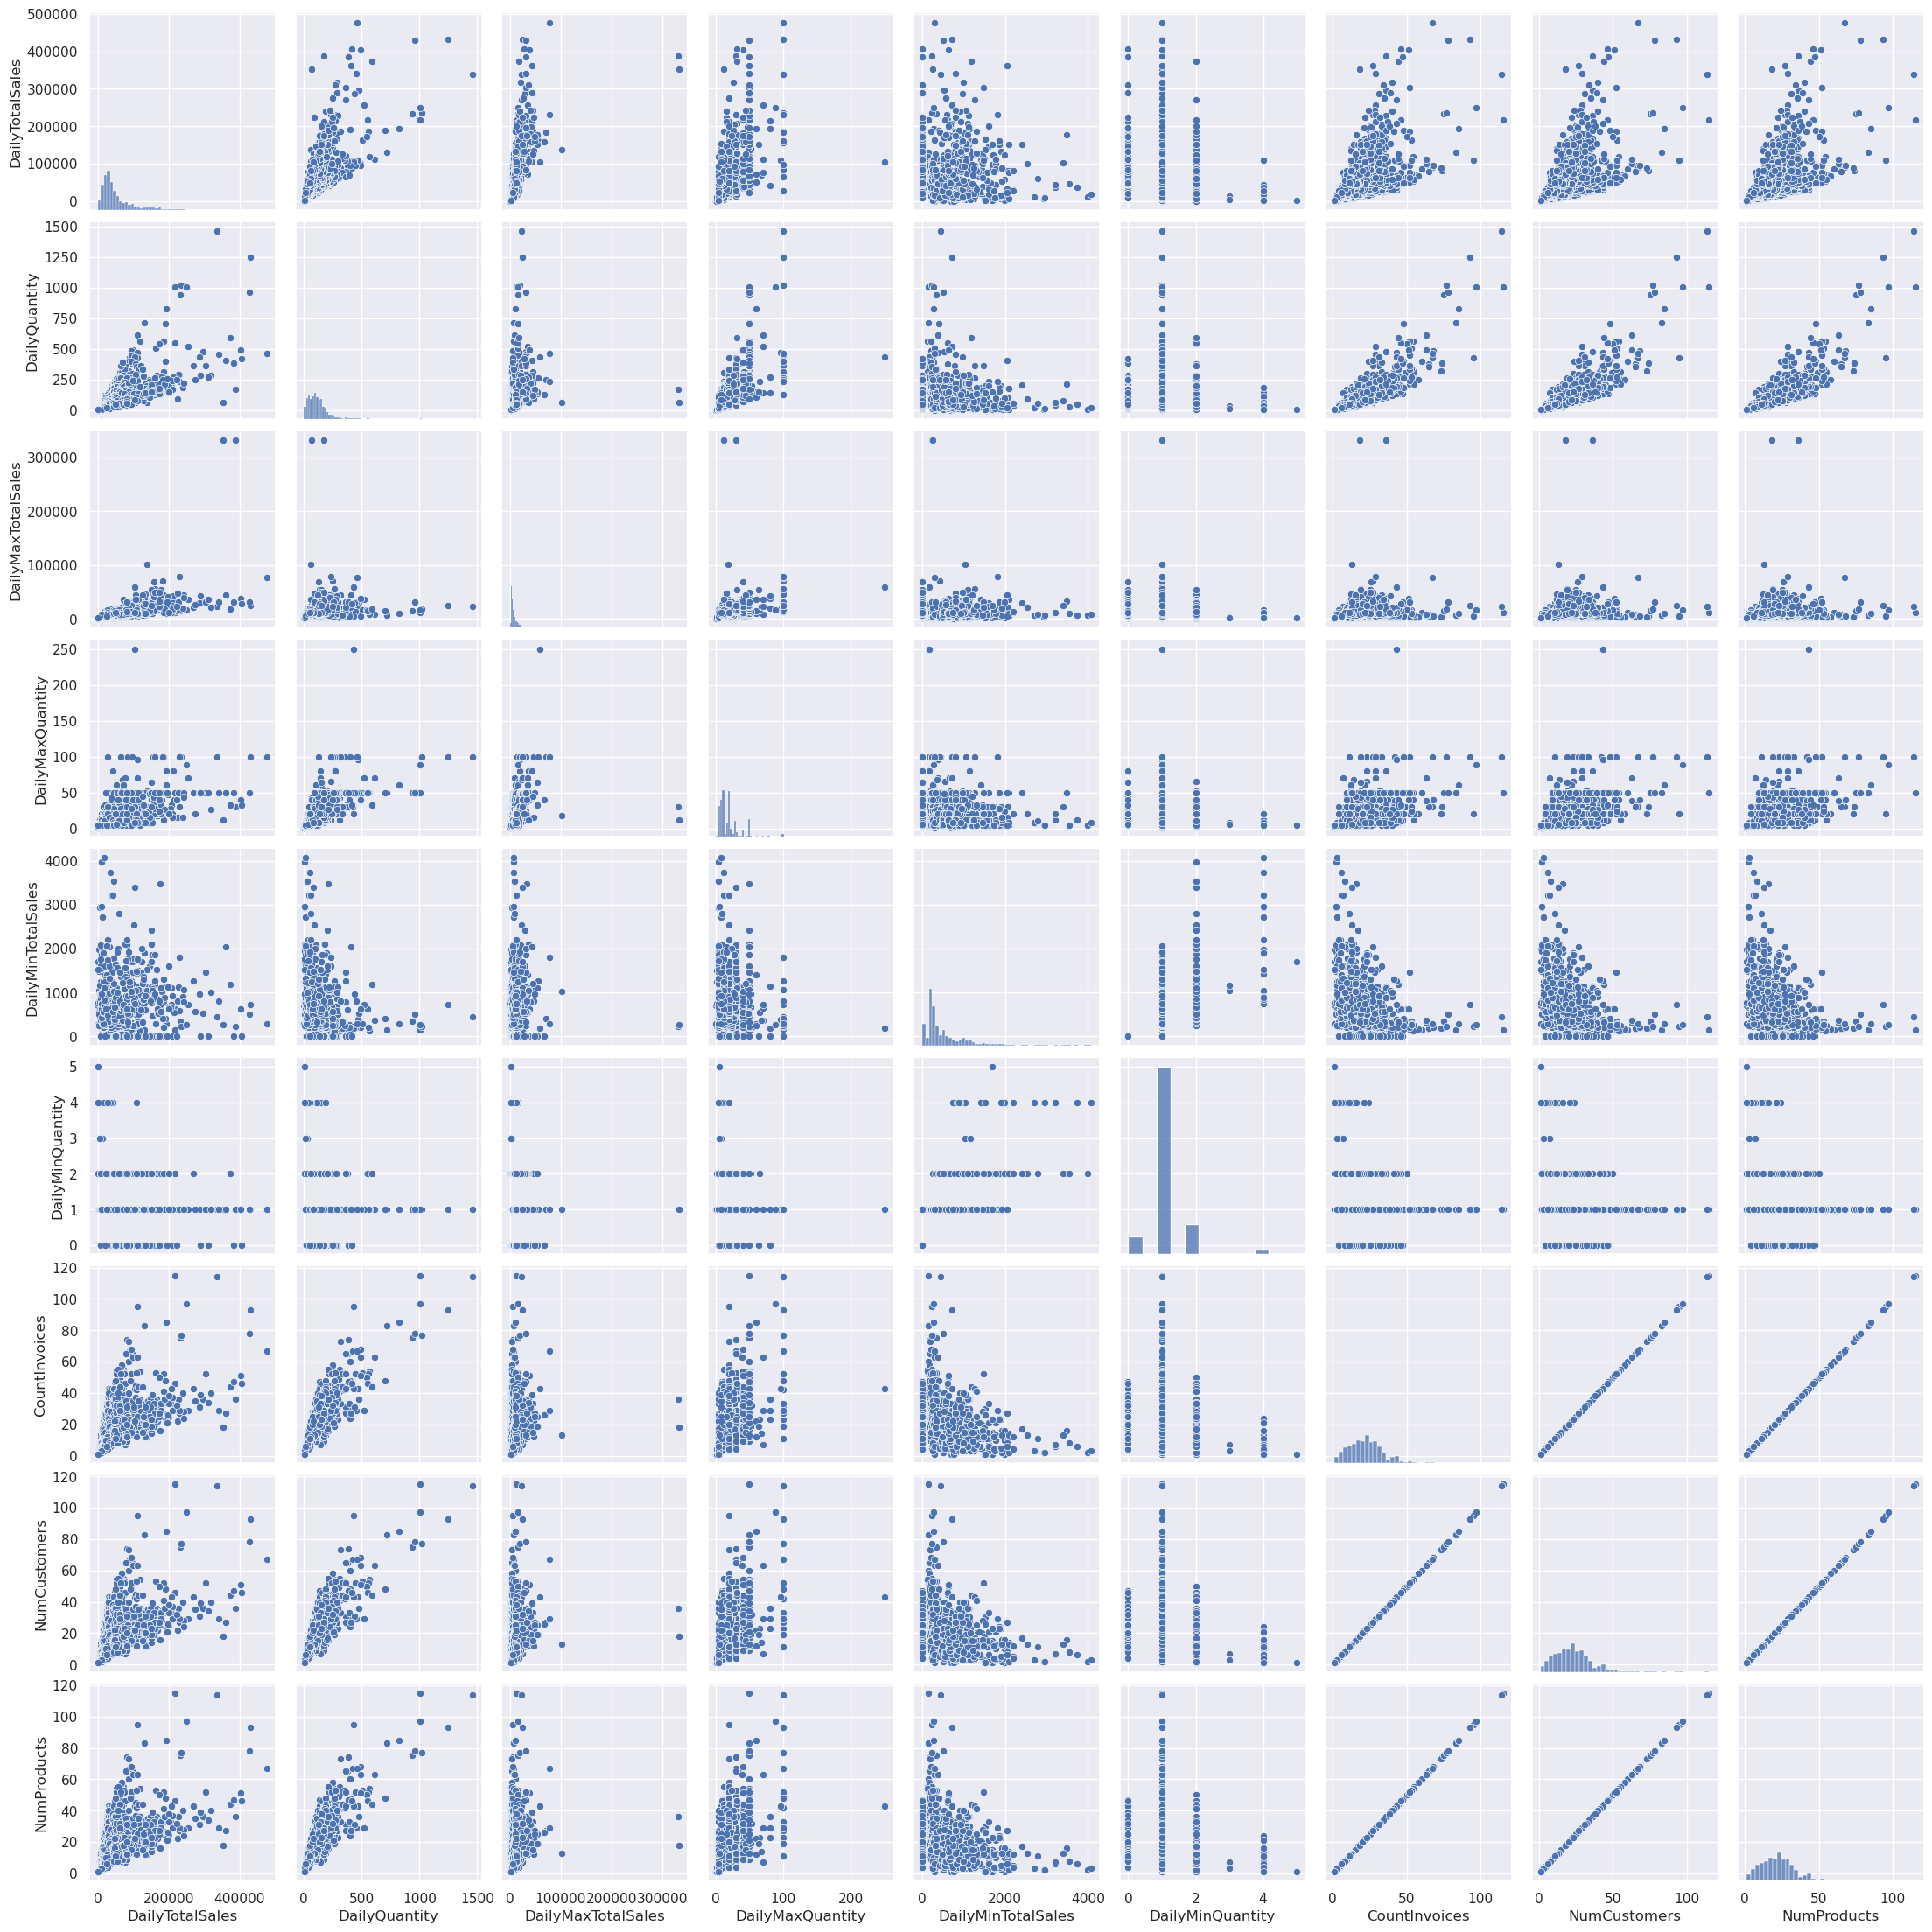

In [11]:
#scatterplot
sns.set()
cols = df_ts.columns
sns.pairplot(df_ts[cols], height = 2.5)
plt.show();

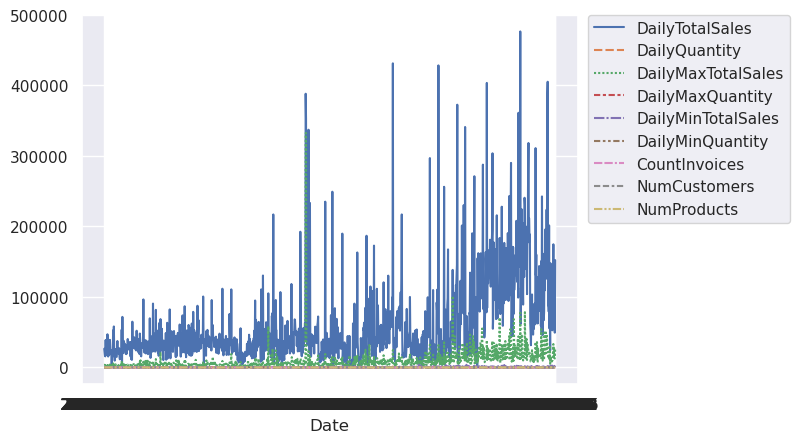

In [12]:
sns.lineplot(data=df_ts[df_ts.columns])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

Obviously the domains are completely different than each other in the time series, let's normalize the data with min-max normalizer and try to visualize one more time:

In [13]:
mms = MinMaxScaler()
df_ts_norm = pd.DataFrame(mms.fit_transform(df_ts),columns = df_ts.columns)
df_ts_norm.head()


,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
0,0.055052,0.074023,0.007855,0.044177,0.048750,0.2,0.254386,0.254386,0.254386
1,0.043729,0.034270,0.008321,0.028112,0.062500,0.2,0.149123,0.149123,0.149123
2,0.034677,0.043866,0.008314,0.076305,0.089742,0.2,0.114035,0.114035,0.114035
3,0.032399,0.034955,0.015251,0.060241,0.048750,0.2,0.096491,0.096491,0.096491
4,0.081232,0.060315,0.014688,0.028112,0.053333,0.2,0.210526,0.210526,0.210526


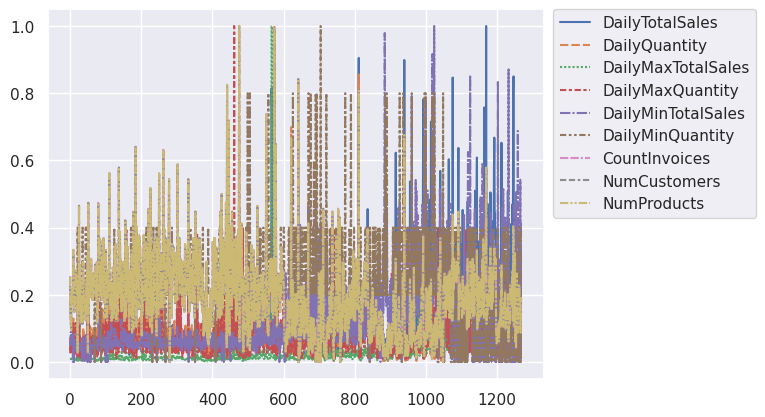

In [14]:
sns.lineplot(data=df_ts_norm[df_ts_norm.columns])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

For a better view, we can proceed with the moving average of each time series:

In [15]:
df_ts_norm_ma = df_ts_norm.rolling(30).mean()
df_ts_norm_ma.dropna(inplace=True)
df_ts_norm_ma.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
29,0.051332,0.063788,0.008531,0.048728,0.055256,0.206667,0.204094,0.204094,0.204094
30,0.050174,0.062394,0.008434,0.048728,0.055517,0.206667,0.199415,0.199415,0.199415
31,0.050441,0.062988,0.008417,0.048728,0.054787,0.206667,0.202339,0.202339,0.202339
32,0.051094,0.063811,0.008558,0.047657,0.053149,0.206667,0.204971,0.204971,0.204971
33,0.051157,0.064336,0.008226,0.047122,0.052740,0.206667,0.207310,0.207310,0.207310


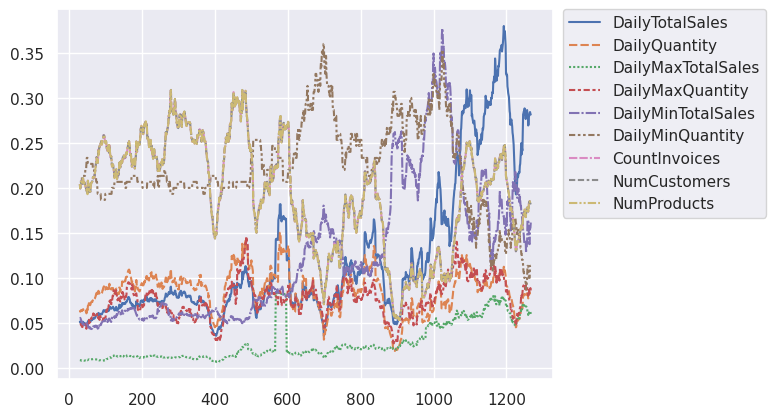

In [16]:
sns.lineplot(data=df_ts_norm_ma[df_ts_norm_ma.columns])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">5. Prediction / Forecasting with CatBoost</p>   
 

In [17]:
print(df_ts.index.min(), '  ----  ', df_ts.index.max())

2019-01-02   ----   2023-03-25


In [18]:
df_ts.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,,
2019-01-02,26514.008475,109,2898.305085,12,198.305085,1,30,30,30
2019-01-03,21119.796609,51,3052.983051,8,254.237288,1,18,18,18
2019-01-04,16807.630509,65,3050.847458,20,365.050847,1,14,14,14
2019-01-05,15722.511525,52,5355.932203,16,198.305085,1,12,12,12
2019-01-07,38985.422907,89,5168.780000,8,216.949153,1,25,25,25


In [19]:
df_train = df_ts[df_ts.index < '2023-01-25' ]
df_test = df_ts[df_ts.index >= '2023-01-25' ]
X= df_train.drop('DailyTotalSales',axis=1)
y = df_train['DailyTotalSales']
X_test = df_test.drop('DailyTotalSales',axis = 1)
y_test = df_test['DailyTotalSales']
X.head()

,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,
2019-01-02,109,2898.305085,12,198.305085,1,30,30,30
2019-01-03,51,3052.983051,8,254.237288,1,18,18,18
2019-01-04,65,3050.847458,20,365.050847,1,14,14,14
2019-01-05,52,5355.932203,16,198.305085,1,12,12,12
2019-01-07,89,5168.780000,8,216.949153,1,25,25,25


Now, we can start with the prediction with Cat Boost Regressor. Also the parameters of the Cat Boost can be fine-tuned, please indicate in the comments, if you have a better parameter setup. 

In [20]:
model = CatBoostRegressor(
    learning_rate=0.1, iterations=1000, eval_metric='RMSE',
    metric_period=50, early_stopping_rounds=20, 
)
model.fit(X, y)


preds = model.predict(X_test)


0:	learn: 54612.7004516	total: 55.9ms	remaining: 55.9s
50:	learn: 13495.4574757	total: 104ms	remaining: 1.93s
100:	learn: 9518.7996994	total: 152ms	remaining: 1.35s
150:	learn: 7855.4798890	total: 199ms	remaining: 1.12s
200:	learn: 6924.7624388	total: 247ms	remaining: 980ms
250:	learn: 6108.5752219	total: 298ms	remaining: 890ms
300:	learn: 5514.5958484	total: 348ms	remaining: 809ms
350:	learn: 5026.9200242	total: 397ms	remaining: 735ms
400:	learn: 4620.0821428	total: 447ms	remaining: 668ms
450:	learn: 4288.3998309	total: 498ms	remaining: 606ms
500:	learn: 3975.4812337	total: 548ms	remaining: 545ms
550:	learn: 3698.1509147	total: 598ms	remaining: 487ms
600:	learn: 3455.2522757	total: 648ms	remaining: 430ms
650:	learn: 3214.5713336	total: 701ms	remaining: 376ms
700:	learn: 3030.7288754	total: 751ms	remaining: 320ms
750:	learn: 2869.4666245	total: 800ms	remaining: 265ms
800:	learn: 2736.4313259	total: 850ms	remaining: 211ms
850:	learn: 2580.3390690	total: 901ms	remaining: 158ms
900:	learn

Let's evaluate the success of the Cat Boost algorithm:

In [21]:
mape = mean_absolute_percentage_error(y_test,preds)
mape

0.15984197789521748

Successful with only 15% of error in the time series. Now we can visualize the predictions vs real data. Let's try to build up a dataframe for visualization:

In [22]:
y_test.to_frame()
y_preds = pd.DataFrame(preds,index = y_test.index,columns=['Predictions'])
y_preds.head()

,Predictions
Date,
2023-01-25,53668.602826
2023-01-26,51274.450433
2023-01-27,106464.404856
2023-01-28,97199.746254
2023-01-30,100547.150513


In [23]:
df_predictions = pd.concat([df_ts['DailyTotalSales'],y_preds],axis = 1)
df_predictions.tail()

,DailyTotalSales,Predictions
Date,,
2023-03-21,104084.737288,104896.305970
2023-03-22,132997.525424,141320.197005
2023-03-23,80991.254236,55065.729703
2023-03-24,49362.644068,54599.412250
2023-03-25,152261.644066,145646.349702


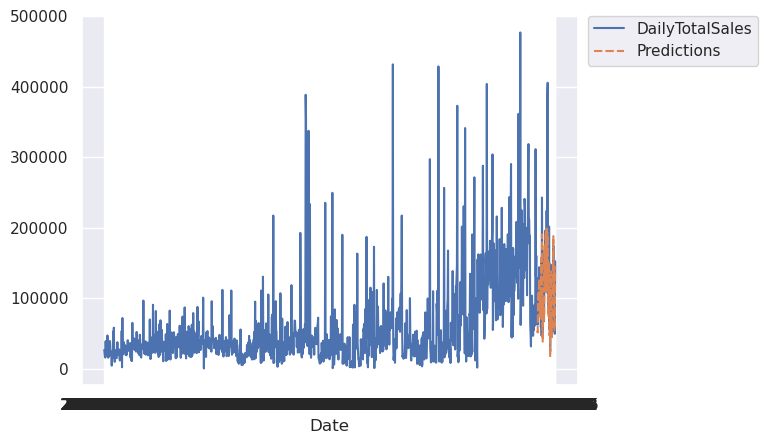

In [24]:
sns.lineplot(data=df_predictions[df_predictions.columns])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

Let's focus only on the prediction period of graph:

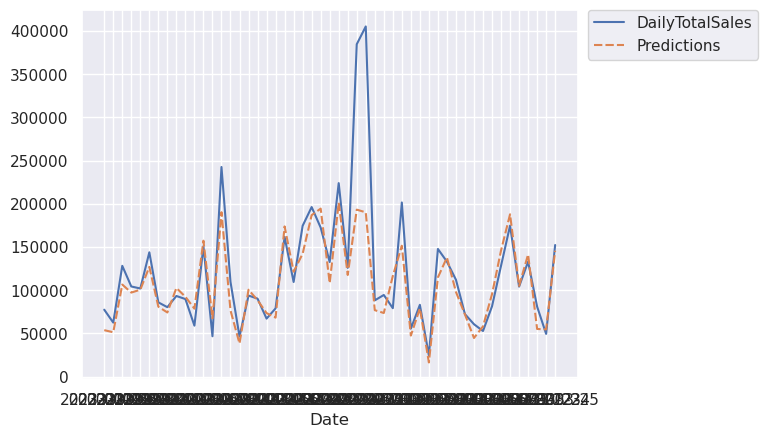

In [25]:
df_predictions = df_predictions[df_predictions.index >= '2023-01-25' ]
sns.lineplot(data=df_predictions[df_predictions.columns])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">7. Real Life Time Series</p> 
   Time Series studies should be taken into account very carefully, the above code does not deal with a real life example, because the features we have extracted are not available in the daily life. For example, let's consider the highest sales per day feature. This feature is only available after the day is completed. So, the real life example will be a bit different than the codes we have implemented until now. So let's try to simulate a real life one:

How can we simulate a real life time series scenario? There are multiple ways for the approach, one would be training the model with older features and predicting the future. So we will add the shifted version of target column for predictions:

In [26]:
df_ts_scenario = df_ts.copy()
df_ts_scenario['DailyTotalSales'] = df_ts_scenario['DailyTotalSales'].shift(-30)
df_train = df_ts_scenario[~df_ts_scenario['DailyTotalSales'].isna() ]
df_train.tail()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,,
2023-02-13,104084.737288,86,24322.033898,28,958.177966,1,17,17,17
2023-02-14,132997.525424,51,10949.152542,8,0.000000,0,18,18,18
2023-02-15,80991.254236,44,11694.915254,4,0.000000,0,17,17,17
2023-02-16,49362.644068,61,12711.864407,12,0.000000,0,14,14,14
2023-02-17,152261.644066,146,49576.271186,50,974.576271,1,27,27,27


We have shifted target column (DailyTotalSales) 30 days and now we can divide the data set into two with last 30 days for test and until last 30 days for training purposes:

In [27]:
df_test = df_ts_scenario[df_ts_scenario['DailyTotalSales'].isna() ]
df_test.drop('DailyTotalSales',axis = 1, inplace = True)
df_test.head()

,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,
2023-02-18,105,17288.135593,12,0.0,0,24,24,24
2023-02-20,132,23288.135593,24,0.0,0,26,26,26
2023-02-21,255,30720.338983,50,0.0,0,21,21,21
2023-02-22,170,49576.271186,50,0.0,0,25,25,25
2023-02-23,122,20377.118644,21,0.0,0,20,20,20


In [28]:
X= df_train.drop('DailyTotalSales',axis=1)
y = df_train['DailyTotalSales']
X_test = df_test
X_test.head()

,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,
2023-02-18,105,17288.135593,12,0.0,0,24,24,24
2023-02-20,132,23288.135593,24,0.0,0,26,26,26
2023-02-21,255,30720.338983,50,0.0,0,21,21,21
2023-02-22,170,49576.271186,50,0.0,0,25,25,25
2023-02-23,122,20377.118644,21,0.0,0,20,20,20


In [29]:
model = CatBoostRegressor(
    learning_rate=0.1, iterations=1000, eval_metric='RMSE',
    metric_period=50, early_stopping_rounds=20, 
)
model.fit(X, y)


preds = model.predict(X_test)


0:	learn: 59185.6342598	total: 1.83ms	remaining: 1.83s
50:	learn: 45635.5036185	total: 53.8ms	remaining: 1s
100:	learn: 41157.9593779	total: 108ms	remaining: 963ms
150:	learn: 38186.0408789	total: 157ms	remaining: 881ms
200:	learn: 35328.7772851	total: 210ms	remaining: 834ms
250:	learn: 32522.5124102	total: 261ms	remaining: 778ms
300:	learn: 30279.7121027	total: 311ms	remaining: 723ms
350:	learn: 28325.7878698	total: 361ms	remaining: 668ms
400:	learn: 26527.1811347	total: 414ms	remaining: 619ms
450:	learn: 24773.6225215	total: 465ms	remaining: 566ms
500:	learn: 23302.0142623	total: 516ms	remaining: 514ms
550:	learn: 21875.1951096	total: 567ms	remaining: 462ms
600:	learn: 20703.2538231	total: 620ms	remaining: 411ms
650:	learn: 19579.2442465	total: 671ms	remaining: 359ms
700:	learn: 18530.8087368	total: 722ms	remaining: 308ms
750:	learn: 17742.6333919	total: 773ms	remaining: 256ms
800:	learn: 16815.3203612	total: 826ms	remaining: 205ms
850:	learn: 16007.5752643	total: 878ms	remaining: 15

In [30]:
X_test.index = pd.to_datetime(X_test.index, format = '%Y-%m-%d')
df_test.index = pd.to_datetime(df_test.index, format = '%Y-%m-%d')
df_test.head()

,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,
2023-02-18,105,17288.135593,12,0.0,0,24,24,24
2023-02-20,132,23288.135593,24,0.0,0,26,26,26
2023-02-21,255,30720.338983,50,0.0,0,21,21,21
2023-02-22,170,49576.271186,50,0.0,0,25,25,25
2023-02-23,122,20377.118644,21,0.0,0,20,20,20


Now we can create the result data frame. The only problem we should handle is the time delta of 30 days after the last date of the original dataset. We first convert the dataset type to datetime and than add 30 days and convert back to string for visualization.

In [31]:
preds_df = pd.DataFrame(preds, index = X_test.index+timedelta(days = 30), columns =['Predictions'])
df_predictions = pd.concat([df_ts['DailyTotalSales'],preds_df],axis = 1)
df_predictions.index = df_predictions.index.astype(str)
df_predictions.head()

,DailyTotalSales,Predictions
Date,,
2019-01-02,26514.008475,NaN
2019-01-03,21119.796609,NaN
2019-01-04,16807.630509,NaN
2019-01-05,15722.511525,NaN
2019-01-07,38985.422907,NaN


we have gathered the original data together with the predictions.

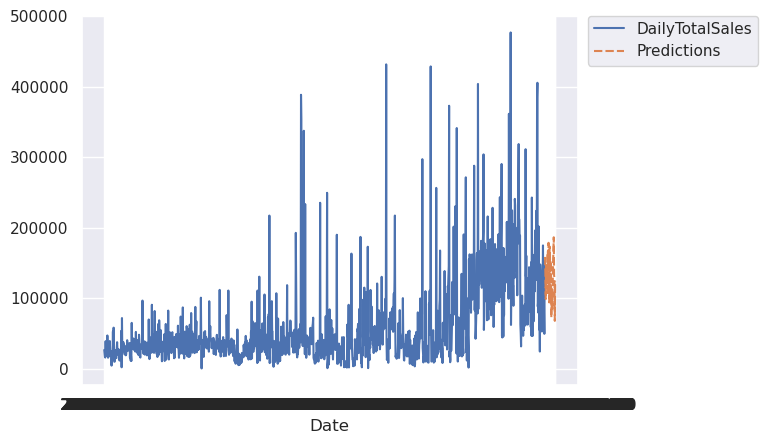

In [32]:
sns.lineplot(data=df_predictions[df_predictions.columns])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

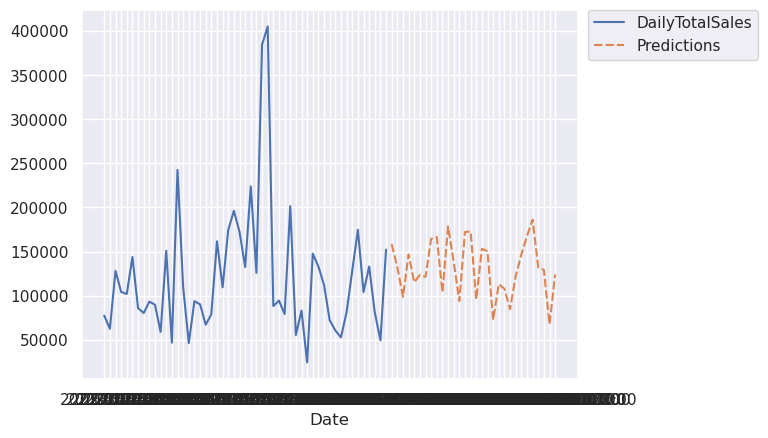

In [33]:
df_predictions = df_predictions[df_predictions.index >= '2023-01-25' ]
sns.lineplot(data=df_predictions[df_predictions.columns])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">7. Conclusion</p> 
    We have started with a sales data in retail industry and created a financial times series and extracted some useful features from the dataset. After the exploratory data analysis (EDA) we have enriched the data with feature engineering and visualized the data for a better view. Next, we have applied CatBoost algorithm for the regression. 
    
    
    The first attempt was about handling the data with Cat Boost and creating relation between the dependendt (Endogenous) variable and independent (Exogenous) variable. Althoug, this approach have a very good result, it is not applicaple in the real life. 
    
    Second attempt was building a time series approach with shifted data. We have shifted the dependent (Endog) variable 30 days, so the machine creates relation between the independent variables and the 30 days delayed target variable. 
    
    Finally we have predicted 30 days ahead with the last 30 days of data and the features we have engineered of course.

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">8. END</p> 
    Hello, my name is Sadi Evren SEKER and this is a notebook just for fun. You can reach me by <a href = "https://www.sadievrenseker.com">https://www.sadievrenseker.com</a> (my homepage) or my udemy courses ( <a href="https://www.udemy.com/user/sadievrenseker/">https://www.udemy.com/user/sadievrenseker/</a> ) or my youtube channel ( <a href ="https://www.youtube.com/@dataconcepts">https://www.youtube.com/@dataconcepts </a> ) or my linkedin profile ( <a href = "https://www.linkedin.com/in/sadiseker/"> https://www.linkedin.com/in/sadiseker/</a>) , bests.